# Explaratory Data Analysis of Capital Bikeshare Trips 2019

    * Basic facts
        - Number of trips
            - Total in 2019
            - By month
            - Daily average, weekend vs weekdays
        - Number of stations
        - Number of bikes
        - Most popular routes
        - Most popular stations
    * Number of trips, duration by:
        - Rider type
        - Time of the trip
            - Month
            - Hour
    * Stations
        - locations
    * Understanding demand
        - 
    * Over time:
        - Usage over time
        - Station expansion over time

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os, timeit
from pathlib import Path
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Data

Capital Bikeshare trips history data is available on [their website](https://www.capitalbikeshare.com/system-data). The data goes back to 2010 and has the following columns:

   * Duration – Duration of trip
   * Start Date – Includes start date and time
   * End Date – Includes end date and time
   * Start Station – Includes starting station name and number
   * End Station – Includes ending station name and number
   * Bike Number – Includes ID number of bike used for the trip
   * Member Type – Indicates whether user was a "registered" member (Annual Member, 30-Day Member or Day Key Member) or a "casual" rider (Single Trip, 24-Hour Pass, 3-Day Pass or 5-Day Pass)
   
In addition, they have cleaned the data to exclude trips taken by the staff and trips that lasted less than a minute, potentially due to false starts or the user unintentionally redocking it. 

Meta data on stations are sourced from [Open Data DC](https://opendata.dc.gov/datasets/capital-bike-share-locations/geoservice). I grab:
    
   * Terminal number
   * Longitude
   * Latitude
   * Address
   * Number of empty docks
   * Number of bikes
    
I download the data using their API. I'm not sure how frequent the updates are, but if it's frequent enough, this data can be used to construct downtime(when a station is full, empty or unavailable to use) as well. 


Both data are pretty clean and easy to use. See modules/preprocess_data.py to see the details on how I downlaod and process them.


If you are interested in deepdiving into the use of Capital Bikeshare, check out [this very rich and detailed development plan from DDT (2016)](https://www.scribd.com/document/331416467/Bikeshare-Development-Plan#from_embed) which combines the trips data with other sources on membership, downtime, neighborhood, and spacial data to create a comprehensive roadmap for the program's impact and expansion. In addition, member survey reports are available on Capital Bikeshare on the same page as their trips data, which provides information that can't otherwise be gathered from use data. 

In [2]:
from modules import preprocess_data
since2019 = [Path(os.getcwd(), 'data', 'raw', f) for f in os.listdir('data/raw') if f.startswith(('2019'))]
trips, stations = preprocess_data.master_data(since2019)

In trips(start) but not in stations: [31202 32031 31008 32051     0], 19,618 trips total
Dropping trips that are not in stations data for now.
In trips(end) but not in stations: [31202 32031 31008 32051     0], 21,076 trips total
Dropping trips that not in stations data for now.


In [3]:
# for scripting purpose
df = trips

## Basic Facts

### Number of trips 

In [4]:
print("Total number of trips in 2019: {:,}".format(df.shape[0]))
df.groupby(['year', 'month']).size().rename('trips').to_frame()

Total number of trips in 2019: 3,357,723


trips
year month        
2019 1      148276
     2      155691
     3      250221
     4      344668
     5      334256
     6      346389
     7      353081
     8      356069
     9      356346
     10     333764
     11     220399
     12     158563

> More rides during warmer months

### Number of stations in use

In [5]:
print("Number of stations in use > 0: {:,}".format(len(df.station_id.unique())))

Number of stations in use > 0: 576


### Number of bikes in use

In [6]:
print("Number of bikes in use> 0: {:,}".format(len(df.bike_number.unique())))

Number of bikes in use> 0: 6,053


### Most popular routes

In [7]:
popular_routes = df.groupby(['start_station', 'end_station']).size().rename('trips').to_frame()
popular_routes.sort_values('trips', ascending=False).head(20)

,,trips
start_station,end_station,
Smithsonian-National Mall / Jefferson Dr & 12th St SW,Smithsonian-National Mall / Jefferson Dr & 12th St SW,4912
Columbus Circle / Union Station,6th & H St NE,4355
6th & H St NE,Columbus Circle / Union Station,3590
4th St & Madison Dr NW,4th St & Madison Dr NW,3528
Jefferson Dr & 14th St SW,Jefferson Dr & 14th St SW,3522
Columbus Circle / Union Station,8th & F St NE,3513
Lincoln Memorial,Jefferson Memorial,3466
Jefferson Dr & 14th St SW,Lincoln Memorial,3066
8th & F St NE,Columbus Circle / Union Station,2976


>Mostly around the mall and downtown, but you can also see 

## Most popular stations by either starting or ending a trip

In [8]:
start = df.groupby(['start_station_id', 'start_station']).size().rename('start').astype(int)
end = df.groupby(['end_station_id', 'end_station']).size().rename('end').astype(int)

start.index.levels[0].name = 'id'
start.index.levels[1].name = 'station'
end.index.levels[0].name = 'id'
end.index.levels[1].name = 'station'

s = pd.merge(start, end, 'outer', left_index=True, right_index=True)

# a peak at stations_use indicates that some station id has multiple station names
# probably slightly different versions of the station names have been recorded over time in trips data
# consolidate station names by picking the first value after the groupby. 
s1 = s.droplevel(1, axis=0)
s1 = s1.groupby(s1.index).sum()

s2 = s.reset_index('station')[['station']]
s2 = s2.groupby(s2.index).apply(lambda x: x.iloc[0,]) # pick the value from the first row
stations_use = pd.concat([s2, s1], axis=1)

# some start values and some end values (for different indices) will be NaN because
# some stations only started trips or ended trips. Replace with 0.
stations_use['start'] = stations_use['start'].fillna(0)
stations_use['end'] = stations_use['end'].fillna(0)
stations_use['usage'] = stations_use['start'] + stations_use['end']

stations_use = stations_use.sort_values('usage', ascending=False)
stations_use.head(20)

,station,start,end,usage
id,,,,
31623,Columbus Circle / Union Station,58495,62949.0,121444.0
31201,15th & P St NW,35050,38094.0,73144.0
31258,Lincoln Memorial,35255,35004.0,70259.0
31289,Henry Bacon Dr & Lincoln Memorial Circle NW,34159,34679.0,68838.0
31288,4th St & Madison Dr NW,32887,33190.0,66077.0
31247,Jefferson Dr & 14th St SW,32142,33577.0,65719.0
31229,New Hampshire Ave & T St NW,34313,30306.0,64619.0
31248,Smithsonian-National Mall / Jefferson Dr & 12t...,31448,32945.0,64393.0
31200,Massachusetts Ave & Dupont Circle NW,28661,35211.0,63872.0


# Trips and Duration

### Trips by Member type

[Text(0, 0.5, 'Percent')]

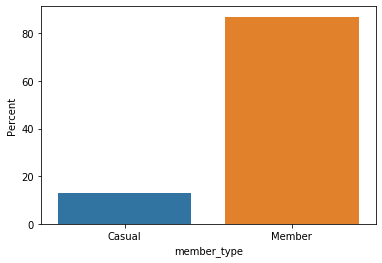

In [9]:
df_member = df.groupby('member_type').apply(lambda x: len(x)/len(df)*100)
df_member
ax = sns.barplot(x=df_member.index, y=df_member.values)
ax.set(ylabel="Percent")

> \>80% of the trips are taken by members

## Duration by Member Type

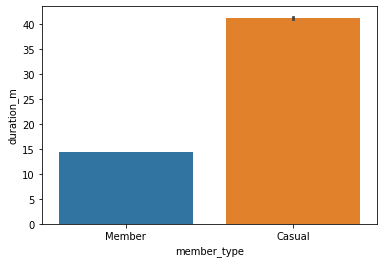

In [10]:
sns.barplot(x='member_type', y='duration_m', data=df)

> The average trip duration in minute shows that casual riders have much longer trips than members, 40 mins vs 15 mins

Capital Bikeshare has a pricing structure where the first 30 mins is free for members and a some price for casual riders, and the price for an additional 30 min block goes up exponentially, starting at \\$2 and capping at \\$8 after an hour and a half. For instance, for memebrs who pay a monthly fee, the first 30 mins is \\$0, the second 30 mins \\$2, the next 30 mins \\$4, and \\$8 for every additional 30 mins beyond that. The inconvenience notwithstanding, it's most economical to return the bike to a station within 30 minutes and check the same bike out if the destination is more than 30 minutes away 

Let's break duration to 30 min blocks

In [11]:
cutoffs = [0, 30, 60, 90, np.Inf]
df['duration_m_cat'] = pd.cut(df.duration_m, cutoffs, right = False)

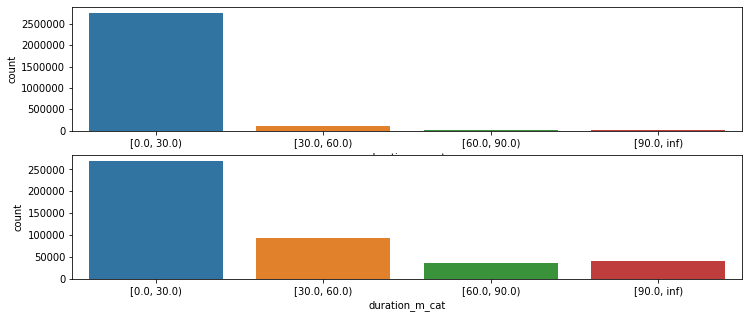

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(12, 5))
sns.countplot(x='duration_m_cat', data=df.query('member_type=="Member"'), ax=ax[0])
sns.countplot(x='duration_m_cat', data=df.query('member_type=="Casual"'), ax=ax[1])

> A considerable share of casual trips are over 1 hour, indicating either casual riders are not price sensitive or don't understand the incremental pricing structure

## By Trip Start Time

Because members and casual riders clearly display different usage, I'll analyze them separately. Looking at the trips by time further shows that members and casual riders have distinctive usage patterns.

### Hour

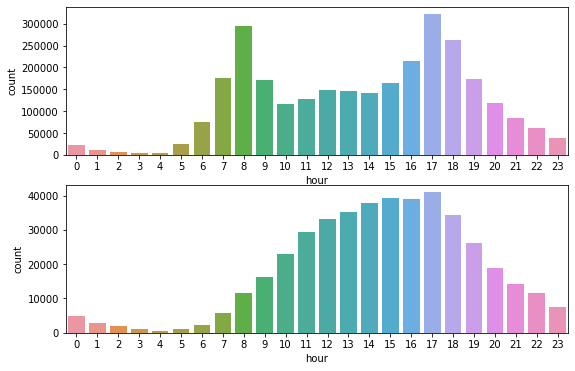

In [13]:
figsize, ax = plt.subplots(2, 1, figsize=(9, 6))
sns.countplot(x='hour', data=df.query('member_type=="Member"'), ax=ax[0])
sns.countplot(x='hour', data=df.query('member_type=="Casual"'), ax=ax[1])

> Member usage peak during commute times while casual usage is normally distributed during the day

### Month

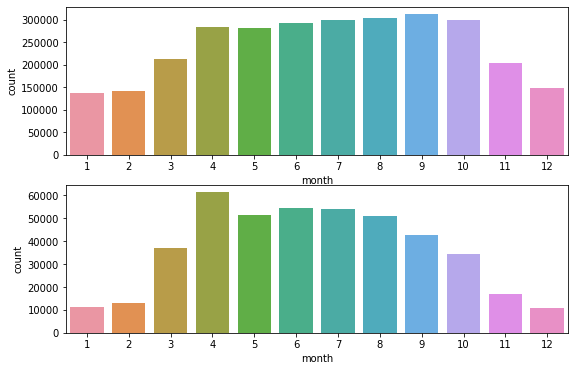

In [14]:
figsize, ax = plt.subplots(2, 1, figsize=(9, 6))
sns.countplot(x='month', data=df.query('member_type=="Member"'), ax=ax[0])
sns.countplot(x='month', data=df.query('member_type=="Casual"'), ax=ax[1])

> Members use the bikes more or less consistently during the warm months (April through October) while casual riders peak in April (cherry blossoms!) and in summer months 

In [ ]:
sns.lmplot(x='duration_m', y='distance', col = 'member_type', data = df.query('duration < 20000'))

KeyboardInterrupt: 

some comments about turnover, 

### Are station usage proportional to the station size?

#### First, look at distribution of capacity

In [ ]:
# There is at least one station in stations_use that is missing capacity 
# because it wasn't in the original data and I couldn't find capacity from the web. Omit that station
su = stations_use[~stations_use.capacity.isna()]
sns.distplot(su.capacity[~su.capacity.isna()], kde=False)

In [ ]:
from scipy.stats import pearsonr
corr, _ = pearsonr(su.usage, su.capacity)
corr

In [ ]:
sns.lmplot(x="usage", y="capacity", data=su)

In [ ]:
from scipy.stats import spearmanr
corr, _ = spearmanr(su.usage, su.capacity)
corr